# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, plot_confusion_matrix

from sklearn import metrics 

In [3]:
from sklearn.ensemble import RandomForestClassifier

In [4]:
PATH = "./data/"

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [5]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv'))
insurance_test = pd.read_csv(os.path.join(PATH, 'porto', 'test.csv'))
insurance_data.shape, insurance_test.shape

((595212, 59), (892816, 58))

Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [6]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])
len(y)

595212

In [7]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [10]:
print(accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid)))


0.9631224658945812


Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

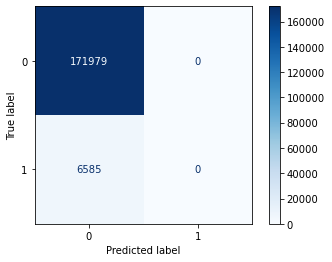

In [11]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [12]:
insurance_data.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.115549e+06,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.488027e+06,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

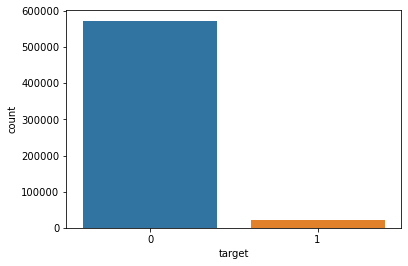

In [13]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [14]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

Gini coefficient is very similar to CAP but it shows proportion (cumulative) of good customers instead of all customers. It shows the extent to which the model has better classification capabilities in comparison to the random model. It is also called Gini Index. Gini Coefficient can take values between -1 and 1. Negative values correspond to a model with reversed meanings of scores.

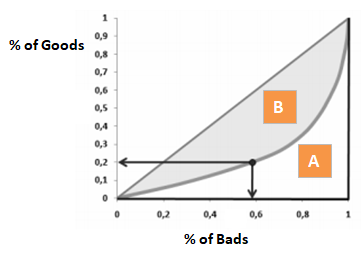

Gini = B / (A+B). Or Gini = 2B since Area of A + B is 0.5

The AUC measure of performance
is closely related to the Gini coefficient, which is sometimes used as an alternative
measure. This is most commonly defined as twice the area between the ROC curve
and the diagonal.... Elementary geometry shows that Gini + 1 = 2AUC”. The same
statement is mentioned by Gajowniczek, Zabkowski and Szupiluk (2014) who write:”
Since the ROC curve measures the inequality between the good and the bad score
distributions, it seems reasonable to show a relation between the ROC curve and
the Lorenz curve. Twice the area between the Lorenz curve and the diagonal line at
45 degree corresponds to the Gini concentration index

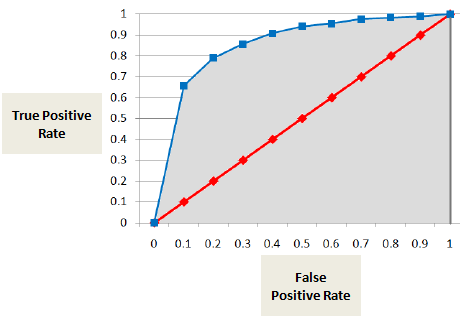

AUC or ROC curve shows proportion of true positives (defaulter is correctly classified as a defaulter) versus the proportion of false positives (non-defaulter is wrongly classified as a defaulter).

Gini = 2*AUC - 1.


If you reverse the axis of chart shown in the above section named "Gini Coefficient", you would get similar to the chart below. Here Gini = B / (A + B). Area of A + B is 0.5 so Gini = B / 0.5 which simplifies to Gini = 2*B. AUC = B + 0.5 which further simplifies to B = AUC - 0.5. Put this equation in Gini = 2*B
Gini = 2*(AUC - 0.5)
Gini = 2*AUC - 1

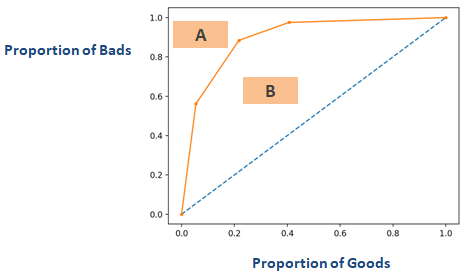

As far as I understand it, improving Gini is like making sure the proba associated with 0s and 1s will sort the labels correctly.
A better AUC always gave a better Gini, which grows from the formula above.

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

As you know, insurance companies don't like to pay money to their clients even then insurance case is in place. They try to minimize amount of insurance payments and keep the money, therefore they can use a dirty way - ask their army of lawers to prove that it all was client's fault and he/she doesn't deserve an insurance payment, or they can go with a smart way - use ML and try to predict the appliant's reliability. The cost of mistake is high, and like in case of cancer predictions, it's better to refuse the application than pay the reckless driver money in the future. So an alternative metric is recall, because their model needs to predict as much True Positives as possible. For example, in accidents prediction. If a accident possibility (Actual Positive) is predicted as non-possible (Predicted Negative), the consequence can be very expenssive for an insurance company. Also, confusion matrix seems to be a very effective metric since you can see your model's weak spots. F1 Score asa well might be a good measure to use if we need to seek a balance between Precision and Recall and there is an uneven class distribution (large number of Actual Negatives).

Let's calculate the Normalized Gini Coefficient:

In [15]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [16]:
y_pred

array([0.02901291, 0.05471013, 0.02670533, ..., 0.02031791, 0.01866532,
       0.13326388])

In [17]:
gini_normalized(y_valid, y_pred)

0.25553017868081573

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

### Resampling

Resampling is a good way to  balance undalanced data - you can add the minority class samples or try and cut the majority class samples.
#### 1. Undersampling
With oversampling we want to reduce the number of the majority class samples, so balanced data will have an equal size of positive and negative samples. In our case, we have 21694 positive samples, so we take 21684 negative samples, append them to positive and make a reduced dataset.

In [18]:
insurance_data['target'].value_counts()

0    573518
1     21694
Name: target, dtype: int64

In [19]:
target_1 = pd.DataFrame()
target_1 = insurance_data[insurance_data['target']==1]
df_sliced = pd.DataFrame()
df_sliced = insurance_data[insurance_data['target']==0]
target_0 = df_sliced[:21694]
target_1.shape

(21694, 59)

In [20]:
undersampled_df = pd.DataFrame()
undersampled_df = undersampled_df.append(target_1)
undersampled_df = undersampled_df.append(target_0)

In [21]:
undersampled_df.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
9,28,1,1,1,2,0,0,0,1,0,...,3,5,0,6,0,1,0,0,1,0
19,64,1,0,1,2,1,0,1,0,0,...,10,3,1,11,0,1,1,0,1,0
28,84,1,0,2,0,1,4,1,0,0,...,3,2,0,8,0,1,1,0,0,0
39,107,1,2,1,3,1,0,0,0,1,...,6,0,8,14,0,1,0,1,0,0
41,110,1,5,2,1,0,0,0,0,1,...,5,2,0,7,1,1,0,0,0,0


In [22]:
y = undersampled_df['target']
X = undersampled_df.drop(columns=['target','id'])
X_test = insurance_test.drop(columns=['id'])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
X_train.shape, y_train.shape

((30371, 57), (30371,))

#### Training model

In [24]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(solver='liblinear', penalty='l2', random_state=14))])

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
clf = pipeline.fit(X_train, y_train)
print(accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid)))

0.6022124913574556


In [26]:
X_train.shape, y_train.shape

((30371, 57), (30371,))

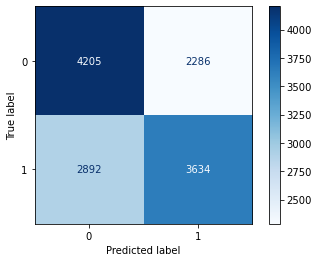

In [27]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

In [28]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [29]:
gini_normalized(y_valid, y_pred)

0.28117604358443776

In [30]:
X_train.shape

(30371, 57)

In [31]:
#X_test = insurance_test.drop(columns=['id'])
y_pred = clf.predict_proba(X_test)[:, 1]

In [32]:
y_pred.shape

(892816,)

#### submission

In [33]:
submission = pd.DataFrame()
submission['id'] = insurance_test['id']
submission['target'] = y_pred   # predict here
submission.head()

,id,target
0,0,0.459979
1,1,0.458715
2,2,0.411901
3,3,0.319456
4,4,0.500437


In [34]:
if len(insurance_test) == len(y_pred):
    print('OK')
    #submission.to_csv('porto_logreg_proba_under_submission.csv', index=False)            #THIS ONE
else:
    print('Error: test and submission different len')

OK


### LogReg undersampled train model Kaggle score - 0.25727

### 2. Oversampling
Next I want to take all majority class samples and add the same amount of the minority class, thus extending data more than twise in size.

In [35]:
#target_0 = pd.DataFrame()
#target_0 = insurance_data[insurance_data['target']==0]
#target_1 = pd.DataFrame()
#target_1 = insurance_data[insurance_data['target']==1]

#oversampled_df = pd.DataFrame()
#oversampled_df = oversampled_df.append(target_0)
#for i in range(len(target_0)//len(target_1)):
    
#    oversampled_df = oversampled_df.append(target_1)

#oversampled_df.shape

In [36]:
#oversampled_df['target'].value_counts()

#### Training oversampled LogReg model

In [37]:
#y = oversampled_df['target']
#X = oversampled_df.drop(columns=['target','id'])
#X_test = insurance_test.drop(columns=['id'])
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [38]:
#X_train.shape, y_train.shape, X_test.shape

In [39]:
#clf = pipeline.fit(X_train, y_train)
#print(accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid)))

In [41]:
#disp = plot_confusion_matrix(clf, X_valid, y_valid,
#                             cmap=plt.cm.Blues,
#                             normalize=None)

#### Working with test data

In [42]:
#y_pred = clf.predict_proba(X_valid)[:, 1]
#gini_normalized(y_valid, y_pred)

In [43]:
#y_pred = clf.predict_proba(X_test)[:, 1]
#y_pred.shape

#### submission

In [44]:
#submission = pd.DataFrame()
#submission['id'] = insurance_test['id']
#submission['target'] = y_pred   # predict here
#submission.head()

In [45]:
#if len(insurance_test) == len(y_pred):
#    print('OK')
    #submission.to_csv('porto_log_over_submission.csv', index=False)            #THIS ONE
#else:
#    print('Error: test and submission different len')

### LogReg oversampled train model Kaggle score - 0.25727

It doesn't have any imrovements, so I hide the code.

### Calculation


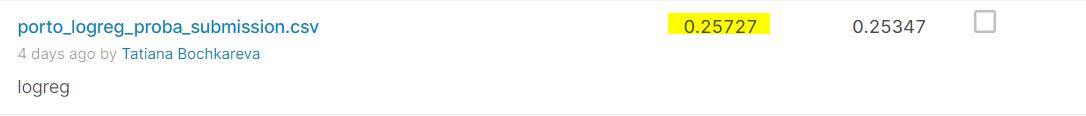

In [1]:
round(200 * max(0.25727 - 0.253,0)) / 2

0.5